<a href="https://colab.research.google.com/github/gcbirat12/All_Projects/blob/main/Copy_of_dtsa_5799_unsupervised_text_classification_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised Text Classification for Marketing Analytics (Nike)
This project uses topic modeling and clustering on Amazon product review data for Nike products. I extracted the relevant reviews and product metadata, preprocessed the text, applied both LDA for topic modeling and K-Means for clustering, and visualized the topics using word clouds. Below is an overview of my work.

##1. Mounting Google Drive and Setting File Paths
I mounted my Google Drive so I could access the input data files. I then defined the file paths for the metadata and review data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

meta_file_path = '/content/drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz'
reviews_file_path = '/content/drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry.json.gz'


Mounted at /content/drive


##2. Extracting Nike ASINs from Product Metadata
I loaded the metadata file and iterated over each product, checking if the 'brand' field contains "nike". If it does, I saved the product’s ASIN.

In [3]:
# ONE CODE CELL: Copy, paste, and run in Colab

# 1. Force-mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. Copy files from Drive to local storage (helps avoid streaming errors)
!cp "/content/drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz" "/content/meta_Clothing_Shoes_and_Jewelry.jsonl.gz"
!cp "/content/drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry.json.gz" "/content/reviews_Clothing_Shoes_and_Jewelry.json.gz"

meta_file_path = "/content/meta_Clothing_Shoes_and_Jewelry.jsonl.gz"
reviews_file_path = "/content/reviews_Clothing_Shoes_and_Jewelry.json.gz"

import gzip
import json
import pandas as pd
from tqdm import tqdm

# -----------------------
# Extract Nike ASINs
# -----------------------
nike_asins = set()
with gzip.open(meta_file_path, 'rt', encoding='utf-8') as f:
    for line in tqdm(f, desc="Extracting Nike ASINs"):
        product = json.loads(line)
        brand = product.get("brand", "").lower()
        if "nike" in brand:
            asin = product.get("asin")
            if asin:
                nike_asins.add(asin)

# Q1: How many ASINs in the full list of Nike ASIN values?
print("Answer to Question 1:", len(nike_asins))

# -----------------------
# Filter reviews for these Nike products
# -----------------------
nike_reviews = []
with gzip.open(reviews_file_path, 'rt', encoding='utf-8') as f:
    for line in tqdm(f, desc="Filtering reviews for Nike products"):
        review = json.loads(line)
        if review.get("asin") in nike_asins:
            nike_reviews.append(review)

# Convert to DataFrame
df = pd.DataFrame(nike_reviews)
print("Nike reviews DataFrame shape:", df.shape)

# -----------------------
# Q2 & Q3: Best ranking Nike ASIN and its rank
# -----------------------
best_ranking_asin = None
best_ranking_value = float('inf')

with gzip.open(meta_file_path, 'rt', encoding='utf-8') as f:
    for line in tqdm(f, desc="Finding best (smallest) sales rank"):
        product = json.loads(line)
        brand = product.get("brand", "").lower()
        if "nike" in brand:
            sales_rank = product.get("salesRank", {})
            if sales_rank:
                for category, rank_value in sales_rank.items():
                    if rank_value < best_ranking_value:
                        best_ranking_value = rank_value
                        best_ranking_asin = product.get("asin")

print("Answer to Question 2 (Best-ranking Nike ASIN):", best_ranking_asin)
print("Answer to Question 3 (Its sales rank):", best_ranking_value)

# -----------------------
# Q4: How many Nike product reviews are for products that rank <= 3000?
# -----------------------
top_reviews_indices = []

with gzip.open(meta_file_path, 'rt', encoding='utf-8') as f:
    for line in tqdm(f, desc="Finding Nike products with rank <= 3000"):
        product = json.loads(line)
        brand = product.get("brand", "").lower()
        if "nike" in brand:
            sales_rank = product.get("salesRank", {})
            if sales_rank:
                for category, rank_value in sales_rank.items():
                    if rank_value <= 3000:
                        asin = product.get("asin")
                        # Find all reviews for this ASIN in df
                        product_reviews = df[df['asin'] == asin]
                        top_reviews_indices.extend(product_reviews.index.tolist())
                        # Break so we don't double-count the same ASIN across multiple categories
                        break

print("Answer to Question 4 (# of reviews for products ranked <= 3000):", len(top_reviews_indices))


Mounted at /content/drive


Extracting Nike ASINs: 1503384it [00:28, 53374.72it/s]


Answer to Question 1: 320


Filtering reviews for Nike products: 5748920it [01:07, 84766.67it/s] 


Nike reviews DataFrame shape: (1958, 9)


Finding best (smallest) sales rank: 1503384it [00:27, 54140.24it/s]


Answer to Question 2 (Best-ranking Nike ASIN): B008FPYDNC
Answer to Question 3 (Its sales rank): 605


Finding Nike products with rank <= 3000: 1503384it [00:28, 52805.81it/s]

Answer to Question 4 (# of reviews for products ranked <= 3000): 299


In [ ]:
import gzip
import json
from tqdm import tqdm

nike_asins = set()

with gzip.open(meta_file_path, 'rt', encoding='utf-8') as f:
    for line in tqdm(f, desc="Extracting Nike ASINs"):
        product = json.loads(line)
        brand = product.get("brand", "").lower()
        if "nike" in brand:
            asin = product.get("asin")
            if asin:
                nike_asins.add(asin)

print(f"✅ Found {len(nike_asins)} Nike ASINs")


Extracting Nike ASINs: 1397578it [00:26, 32260.57it/s]

##3. Filtering Reviews for Nike Products
I then filtered the review data by checking if each review's ASIN is in the set of Nike ASINs I collected. The matching reviews are saved to a list.

In [ ]:
nike_reviews = []

with gzip.open(reviews_file_path, 'rt', encoding='utf-8') as f:
    for line in tqdm(f, desc="Filtering reviews for Nike products"):
        review = json.loads(line)
        if review.get("asin") in nike_asins:
            nike_reviews.append(review)

print(f"✅ Extracted {len(nike_reviews)} reviews for Nike products")


Filtering reviews for Nike products: 5748920it [01:12, 79217.64it/s] 

✅ Extracted 1958 reviews for Nike products


##4. Saving Filtered Reviews
I saved the filtered reviews as a JSON file in my Google Drive for later analysis.

python
Copy


In [ ]:
output_file_path = '/content/drive/MyDrive/nike_reviews.json'

with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(nike_reviews, f, indent=2)

print(f"📄 Nike reviews saved to {output_file_path}")


📄 Nike reviews saved to /content/drive/MyDrive/nike_reviews.json


##5. Loading Reviews into a DataFrame
I loaded the saved JSON data into a Pandas DataFrame, which allowed me to explore and manipulate the data.

In [ ]:
import pandas as pd

with open(output_file_path, 'r', encoding='utf-8') as f:
    nike_reviews = json.load(f)

df = pd.DataFrame(nike_reviews)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print(df.head(20))


        reviewerID        asin                             reviewerName  \
0   A24FR60HTGC9MD  B001AGN0KK                              alex santos   
1    ALPXICXNH4KRU  B001AGN0KK                                    Andre   
2    AVBNYCAL2KZ0H  B001AGN0KK                                   augata   
3   A108RGZJ10ASZP  B001AGN0KK                                     Bulo   
4   A30UJIHAHOL7RK  B001AGN0KK                         californiaman714   
5    AORNZLSBQY92G  B001AGN0KK                                  Catdale   
6   A28L219AR1R628  B001AGN0KK                                     Dana   
7   A3MUII6MG5EEEN  B001AGN0KK                        Denise "luv2read"   
8   A1AEDOTJMZUQBW  B001AGN0KK                           Falah muhammad   
9   A1QAYXHH9ZCHS6  B001AGN0KK                               Fred Gagne   
10  A19KNCL8Q29E79  B001AGN0KK                            George Zander   
11  A3K3BVAXOFSY8X  B001AGN0KK  Hummingbird Girl "In love with romance"   
12  A1ZPRJWAVMCBVC  B001A

##6. Text Preprocessing
I preprocessed the review text by converting it to lowercase, removing punctuation and numbers, eliminating extra spaces, removing stopwords, and applying lemmatization. This step is crucial for accurate topic modeling.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [w for w in words if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

from tqdm import tqdm
tqdm.pandas(desc="Preprocessing reviews")
df['cleaned_review'] = df['reviewText'].progress_apply(preprocess_text)

print(df[['reviewText', 'cleaned_review']].head(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
Preprocessing reviews: 100%|██████████| 1958/1958 [00:11<00:00, 170.50it/s]

                                                                                                                                                                                                                                                                                                                                                                                                  reviewText  \
0                                                                                                                                                                                                                                                                                                         If you ever want a cap this is the one you want! And for the price, this will be the one you want.   
1                                                                                                                                                                                                       

##7. Topic Modeling with LDA
I converted the cleaned reviews into a document-term matrix using CountVectorizer, then trained a Latent Dirichlet Allocation (LDA) model to extract topics. I displayed the top words for each topic for interpretation.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_review'])

num_topics = 20  # Adjust this number as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[-no_top_words:][::-1]]))

print("### LDA Topic Modeling Results:")
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words=10)


### LDA Topic Modeling Results:

Topic 1:
shirt | sleeve | work | nike | bought | like | really | doesnt | cool | summer

Topic 2:
bag | gym | size | perfect | carry | small | pocket | shoe | need | love

Topic 3:
short | nike | compression | pair | cheap | product | good | material | buying | great

Topic 4:
time | purchase | fit | love | color | like | hat | good | really | happy

Topic 5:
love | great | bought | shoe | gift | nike | product | pleased | sunglass | thanks

Topic 6:
belt | buckle | good | quality | nice | look | leather | like | pretty | high

Topic 7:
loved | price | shoe | look | love | black | good | great | style | nike

Topic 8:
belt | golf | love | great | black | want | nike | husband | fit | wear

Topic 9:
belt | great | product | look | good | buckle | hold | color | size | nice

Topic 10:
bag | use | great | happy | lot | used | comfortable | year | got | purchase

Topic 11:
bra | great | arm | comfortable | fit | sun | feel | sport | sleeve | nike

Topic 12:

##8. Clustering with K-Means
In addition to LDA, I applied K-Means clustering using TF-IDF vectorization to further validate and compare how reviews group together. I then printed the top words for each cluster.

python
Copy


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['cleaned_review'])

num_clusters = 20  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

def print_kmeans_topics(model, vectorizer, top_n=10):
    for i, center in enumerate(model.cluster_centers_):
        top_indices = center.argsort()[-top_n:][::-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        print(f"\nCluster {i + 1}: {', '.join(top_words)}")

print("### K-Means Clustering Results:")
print_kmeans_topics(kmeans, tfidf, top_n=10)


### K-Means Clustering Results:

Cluster 1: shoe, wear, foot, sock, comfortable, size, dont, zumba, like, fit

Cluster 2: sock, foot, great, comfortable, nike, fit, wear, like, black, nice

Cluster 3: pant, wear, suit, short, great, golf, rain, small, swing, play

Cluster 4: time, son, quality, better, happy, buy, short, arrived, say, el

Cluster 5: sunglass, lens, pair, glass, great, running, face, fit, frame, nike

Cluster 6: like, sleeve, nice, nike, cool, arm, color, look, feel, buy

Cluster 7: great, looking, color, arm, fit, nice, place, exactly, stay, im

Cluster 8: product, great, nike, good, received, excellent, price, recommend, quality, nice

Cluster 9: good, quality, price, sock, fit, great, buy, son, like, feel

Cluster 10: bag, gym, perfect, small, carry, need, stuff, hold, size, pocket

Cluster 11: bra, sport, fit, support, comfortable, great, nike, size, bit, perfect

Cluster 12: purchase, happy, definitely, sock, great, nike, love, fit, expected, son

Cluster 13: size,

##9. Visualizing Topics with Word Clouds
I visualized the topics generated by the LDA model by creating word clouds for each topic. This helps me quickly see the key terms that define each topic.

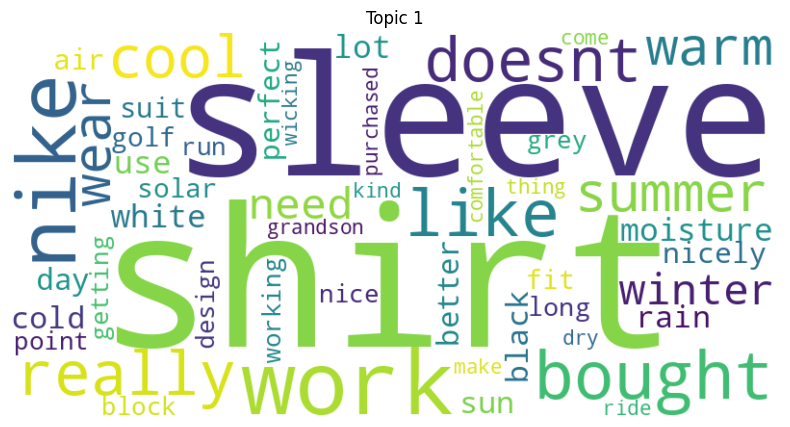

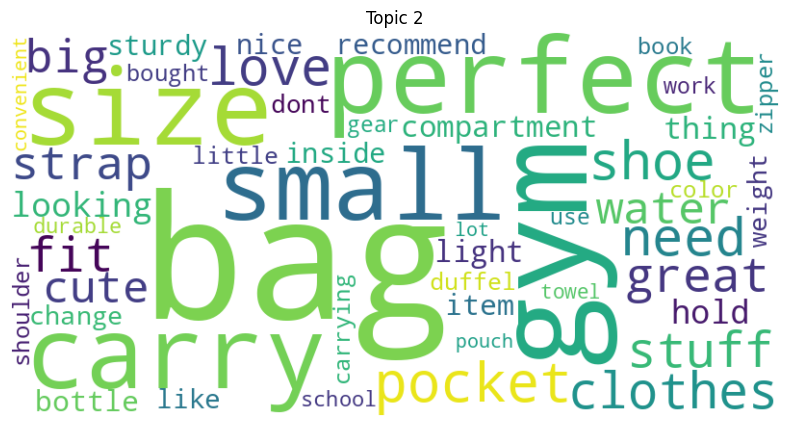

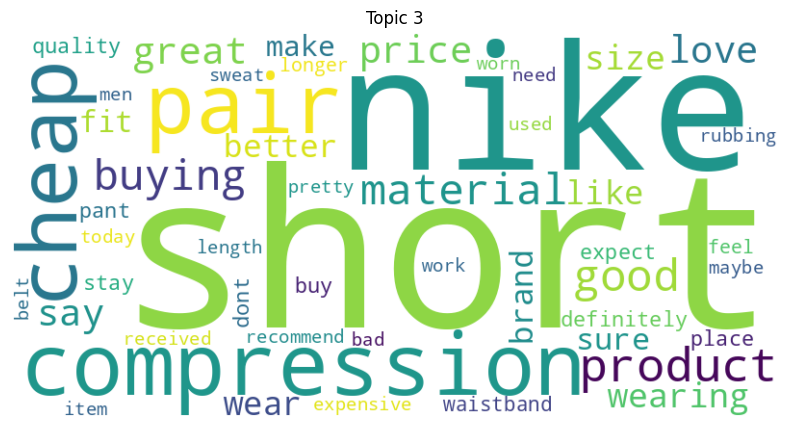

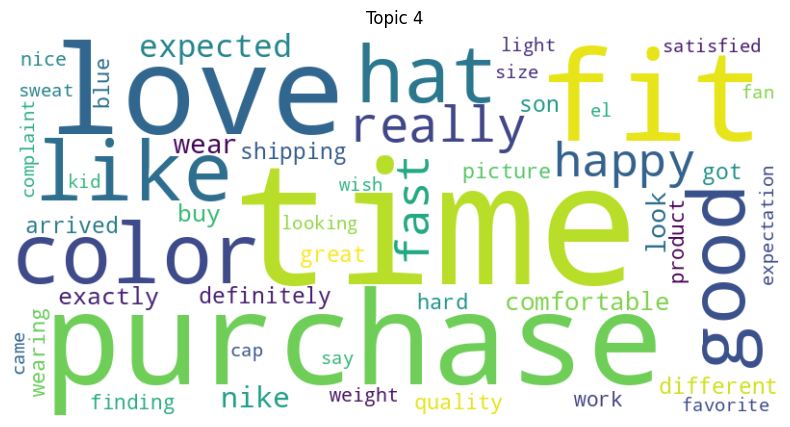

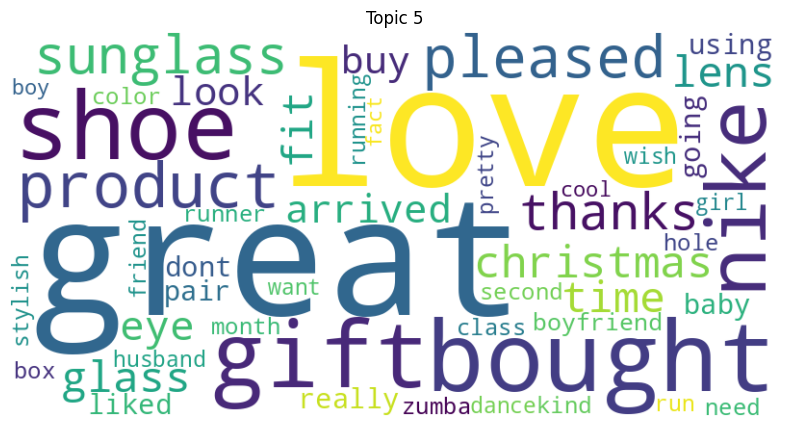

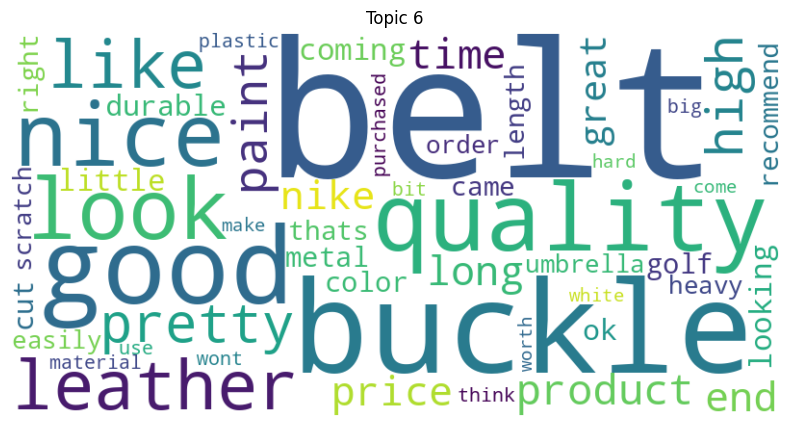

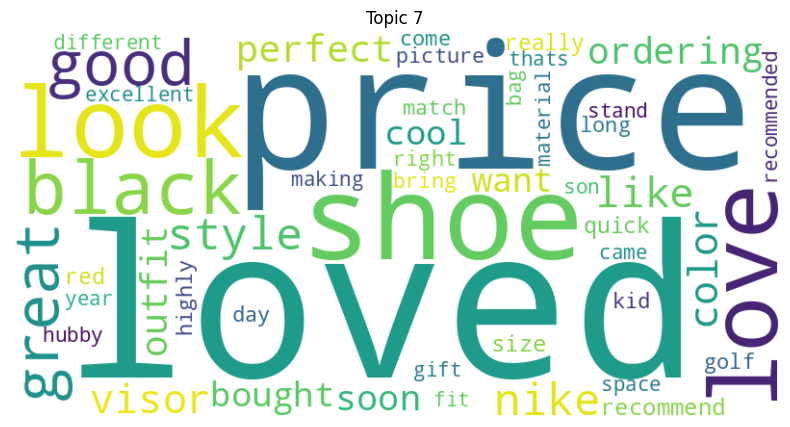

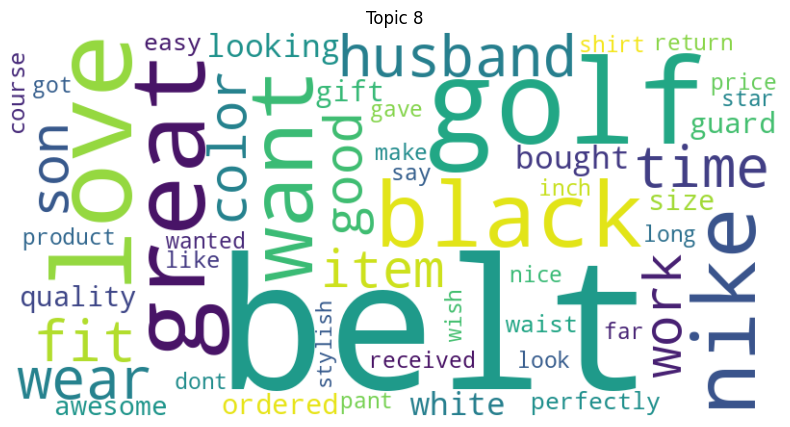

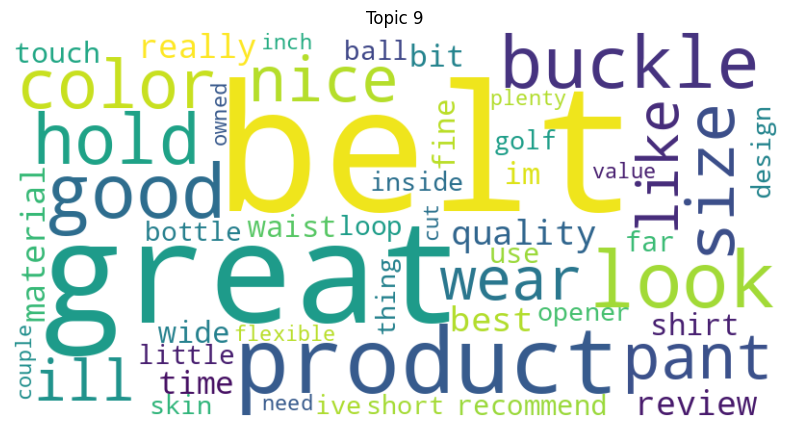

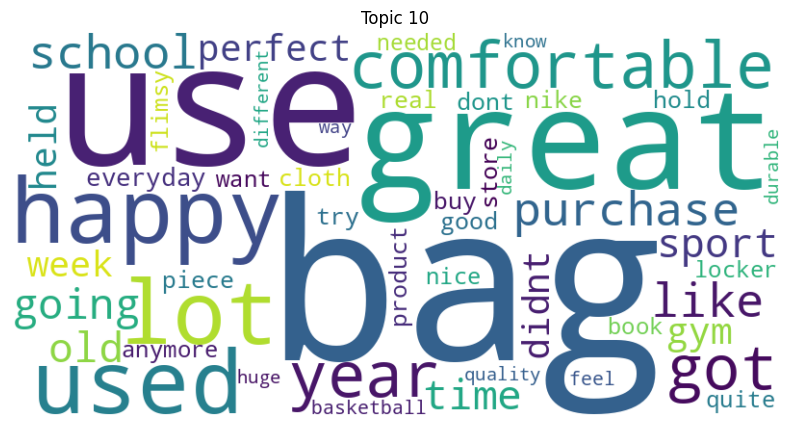

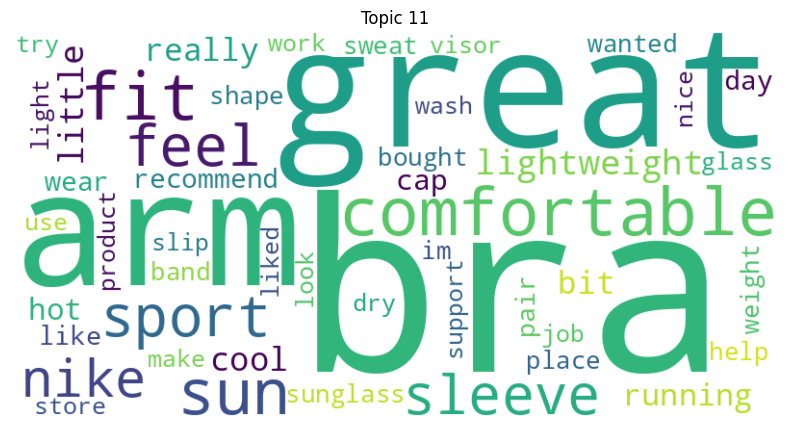

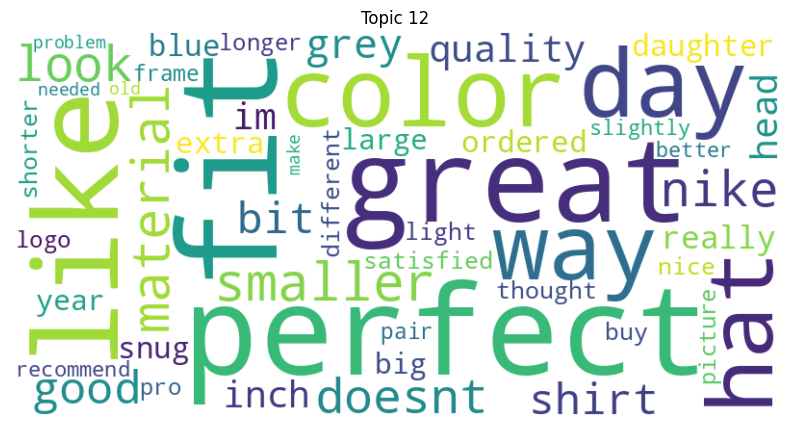

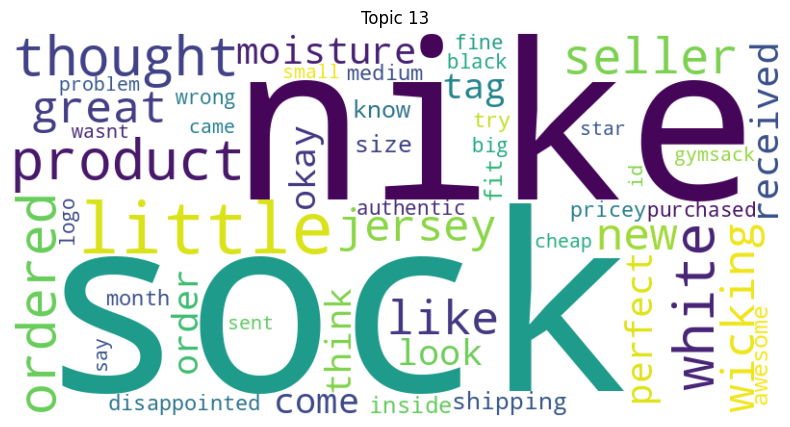

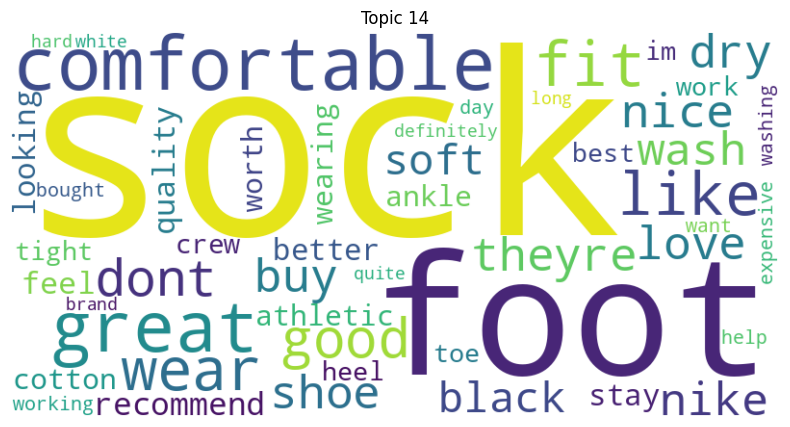

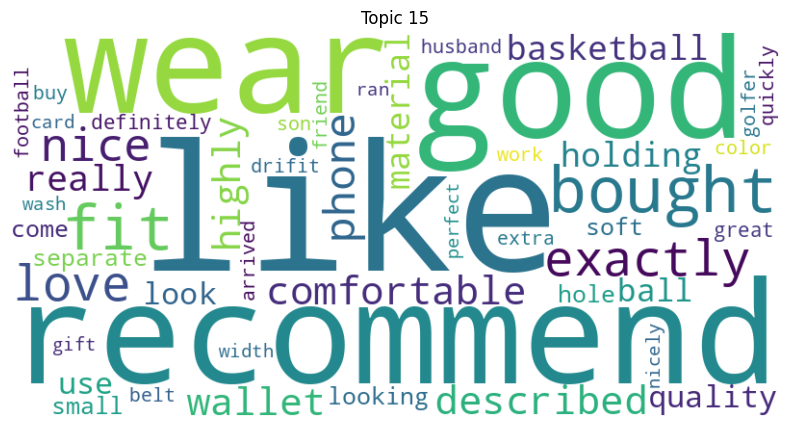

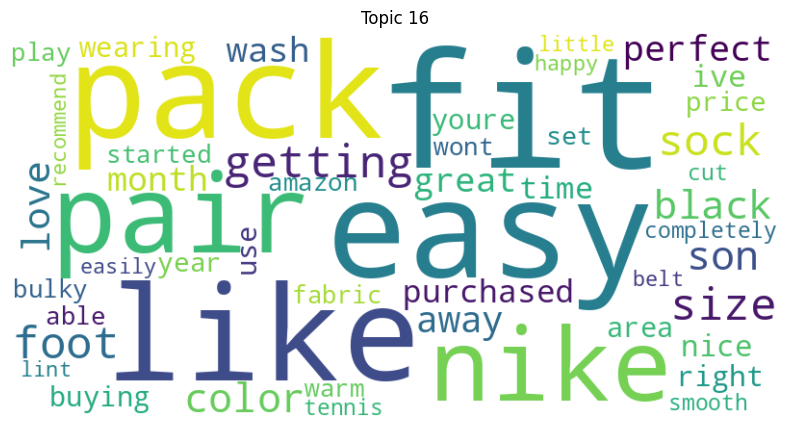

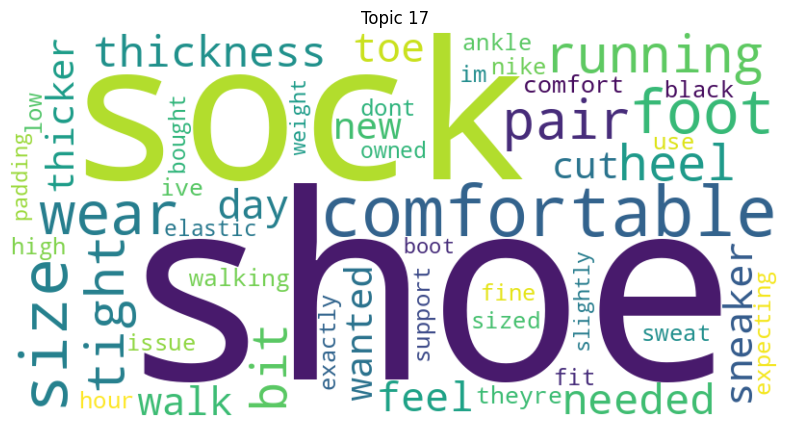

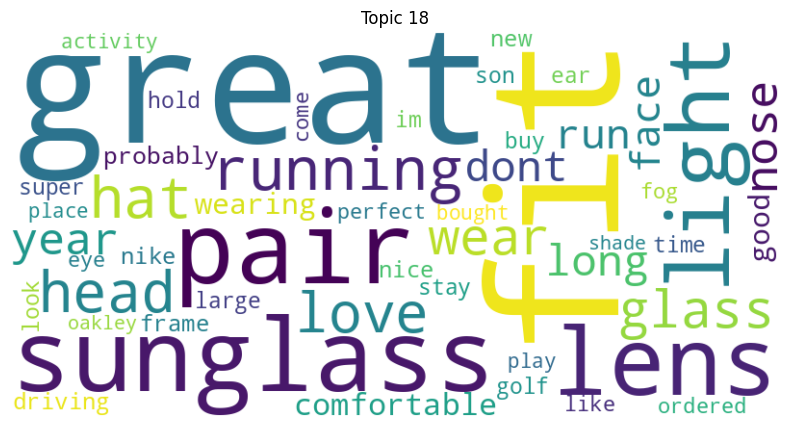

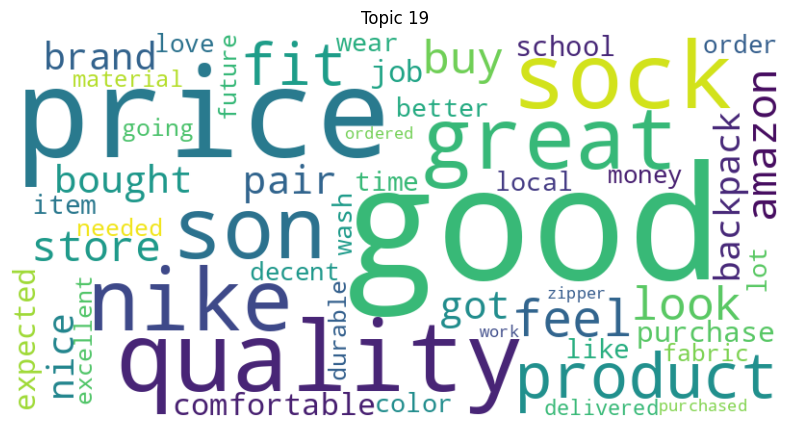

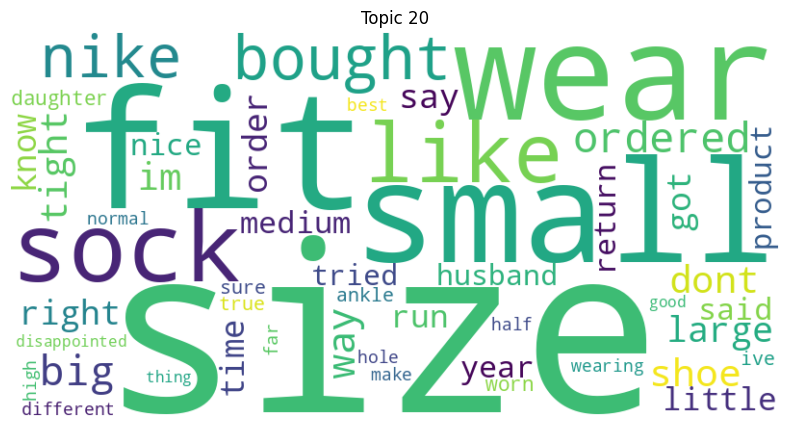

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(10, 5))
    freqs = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-50:]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {idx + 1}")
    plt.show()


##10. Assigning Topics to Each Review
I used the LDA model to assign each review to its most likely topic. This allows me to segment the reviews for further qualitative analysis.

In [ ]:
import numpy as np

topic_assignments = lda.transform(dtm)
df['topic'] = np.argmax(topic_assignments, axis=1) + 1  # +1 for readability
print("### Sample Reviews with Assigned Topics:")
print(df[['asin', 'reviewText', 'cleaned_review', 'topic']].head(10))



### Sample Reviews with Assigned Topics:
         asin  \
0  B001AGN0KK   
1  B001AGN0KK   
2  B001AGN0KK   
3  B001AGN0KK   
4  B001AGN0KK   
5  B001AGN0KK   
6  B001AGN0KK   
7  B001AGN0KK   
8  B001AGN0KK   
9  B001AGN0KK   

                                                                                                                                                                                                                                                                                                                                                                                                  reviewText  \
0                                                                                                                                                                                                                                                                                                         If you ever want a cap this is the one you want! And for the price, this 

##11. Inspecting Reviews by Topic
I created a function to sample a few reviews from each topic. This step helps me ensure that the topics make sense and capture distinct themes.

In [ ]:
def inspect_reviews_by_topic(topic_num, sample_size=12):
    sample_reviews = df[df['topic'] == topic_num].sample(sample_size)
    return sample_reviews[['asin', 'reviewText', 'topic']]

for topic_num in range(1, num_topics + 1):
    print(f"\n📝 Reviews for Topic {topic_num}:")
    display(inspect_reviews_by_topic(topic_num))



📝 Reviews for Topic 1:


asin  \
1667  B00ANTSXTI   
1919  B00DSQV1N8   
1060  B005I6O8VS   
1285  B00799NBUQ   
1099  B005I6OBN8   
1335  B007QXSE0C   
1197  B0064NHS3Y   
1023  B005I6O8VS   
154   B002PAPQCU   
1157  B0060LEKOA   
1336  B007QXSE0C   
178   B002PAPQCU   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                reviewText  \
1667                                                                                                                                                                                                                                                                                                                                                                                                                                                   I bought them to wear to work as black dress socks so that I could hit the gym after work seamlessly without changing sock. The work well in this fashion, but here are some pros and cons:Pros: Look nice, fit well, all cottonCons: Wear down quickly (as expected with all cotton socks), lose fit throughout day, they lose some of their blk color after washing several times   
1919                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Perfect sizeMesh on the bottom to air out, awesome!!!!!Works for the gym, when I run to work, when I ride my bike and for a make shift work bag!!!THANK YOU   
1060                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Multi-sport athlete that found use for these sleeves in almost every sport that I play.  Sleeves will protect and keep warm.  Would def buy again.   
1285                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          I


📝 Reviews for Topic 2:


asin  \
479   B004MU21EC   
817   B00515GEJK   
715   B004UBWORW   
807   B00515GEJK   
801   B00515GEJK   
706   B004S7FCCC   
1129  B005OBDSXQ   
849   B005525IGO   
880   B005525IGO   
777   B00515GEJK   
782   B00515GEJK   
825   B00515GEJK   

                                                                                                                                                                                                                                                                                                                                                                                                                                                          reviewText  \
479   This is a very nice looking backpack and if your just going to the gym it's great, forget about it if you need it for school.  Very small, hard to adjust the books and folders to fit and after three weeks the zipper broke!!  If ordering from Sneaker Kingdom Shoe Shop, DON'T!!  They would not take the bag back and made me go through Nike to get a refund/exchange!!!!  Still waiting on the outcome.  $55.00 is a lot of money to just "throw away".   
817                                                                                                                                      This is a very well constructed and light weight duffle bag in a super convenient size for smaller needs.  My college student son uses it for carrying around his workout clothes to classes so he can go to the gym directly after classes without walking all the way back to his car.  It's difficult to find this size.   
715                                                                                                                                                                                                                                                                                                                      This backpack is ideal for carrying a number of text books and then some.  Perfect!  Exactly what I was looking for in back to school gear.   
807                                                                                                                                                                                                                                                                                                                                                           Love it, it's cute and small, fits lots of stuff, the pocket in the front comes in handy, very useful!   
801                                                                                                                                                                                                                                                                                                                                                                                                  This bag is a perfect fit.  It's not too big and not too small.   
706                                                                                                                                                                                                                                                                                       I was very pleased with this book bag. Very sturdy and nice. My son absolutley loves it and not to mention it came very quickly!!Thanks Amazon. I will be ordering again!!   
1129                                                                                                                                                                                                                                                                                                       This is a good sized sports bag which is cool looking and functional. It can fit a pair of shoes, a toiletry bag, a bath towel and some clothes. Perfect!   
849                                                                                                    


📝 Reviews for Topic 3:


asin  \
46    B001GUN9IS   
517   B004NP2BZK   
59    B001GUN9IS   
1566  B00ANTSXTI   
412   B004ARVTWM   
1827  B00BZAP3WY   
1328  B007PIYZ8S   
1204  B0064NHS3Y   
1154  B0060LEKOA   
540   B004PKJ3XG   
1532  B00ANTSXTI   
847   B005525IGO   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                reviewText  \
46    I have bought several pairs of compression shorts online because you can't find any in the stores anymore. These shorts are the only ones that actually reflect their description. They are knee length and don't keep riding up my thighs when working out.I now have four pairs, (I thought I better stockpile a few in case they vanish into cyberspace). I hope they never do, because I will be buying these shorts before any other.Absolutely deserve five stars in my book!!   
517                                                                                                                                                                                                                                                                                                                                                                   Fit as described (per size) and comfortable.  For 6 pair it is a little pricey but what do you expect from Nike. . .   
59                                                                                                                                                                                                                                  The Nike compression shorts fit very well and give excellent support. I would recommmendthem for the serious or casual athlete.They are the best compression shorts I have ever owned.Definitely wouldn't buy another brand-nothing compares to these.   
1566                                                                               I love these. Great for the gym these days, now that we're wearing them longer again. :)And versatile, because I can wear them with jeans, too.Good quality, feel good.And while I normally prefer few to no logos on my clothes, I make an exception here. It's nice to have the Nike logo so that it's clear I intended the black sox at the gym, and I'm not my dad, wearing my dress sox. hahahaha.   
412                                                                                                                                                                                                                                                                                                                                        Package arrived quickly. Socks are just as described and comfortable! Feels great wearing with my nike trainers. Will definitely be buying more   
1827                                                                                                                                                                                                                                                                                                                                                           What more to say than great product.  These provide good compression on your feet, stay dry, and say which foot they go on.   
1328                                                                                                                                                                                                                                                                                                                                        Cool.corresponded to this product if specified and is satisfied with what


📝 Reviews for Topic 4:


asin  \
1700  B00AWVQXBM   
672   B004Q7BLPG   
589   B004PKJ3XG   
874   B005525IGO   
470   B004JGKZH4   
955   B0059WMO6W   
1502  B00A0ZJP4M   
1784  B00BBHGG68   
1408  B008KZTUZI   
371   B0046VXJ0W   
1448  B009JHWJWC   
301   B003DSI5JY   

                                                                                                                                                                                                                   reviewText  \
1700                                                                                                         The shirt arrived on time and in it's original packaging. It is a quality shirt that is stylish and comfortable.   
672                                                                        socks are socks, but these fit good and wash out very well.  I am completely satisfied with this purchase and would purchase again when necessary.   
589                                                                     Excellent product, I got just what I was looking for. The belt in the picture is exactly what you recieve, atleast for the black(the one I purchased)   
874   Orden&eacute; este producto desde venezuela y llego en buenas condiciones tal y como est&aacute; en la descripci&oacute;n. El producto es de buena calidad y servir&iacute;a para llevar una muda de camisa o de botas.   
470                                                                                                    Exactly what we were looking for. About $ 30 more then we got at an outlet store, but didn't have to drive 150 to get.   
955                                                                                             I love my shoes, they are stylist and comfortable. I am happy I chose them. They arrived on time and I highly recommend them.   
1502                                                                I rate my purchase with 5 stars.  They fit great, arrived early, and I got to re-live a childhood memory.  I'm 29 I had these same sneakers when I was 9.   
1784                                                                                              They look great and fit very well.  My fashion-consious, athletic son wears them often.  I would definitely buy them again.   
1408                     Shipped quickly and fits perfectly! The material is very comfortable and fits me well. I am not a fan of many hats, but this one is a definite favorite! I will be wearing this on the golf course!!   
371                                                                                         Socks size 14 are really hard to find.  Very happy to have found this site to purchase size 14 socks.The fit was what I expected.   
1448                                                                                well constructed sunglasses, lightweight, outside us deliver. the only critic they could be cheaper!!. Still very happy whit the purchase   
301                                                                                                                                                                                  Good qualuty product and arrived on time   

      topic  
1700      4  
672       4  
589       4  
874       4  
470       4  
955       4  
1502      4  
1784      4  
1408      4  
371       4  
1448      4  
301       4


📝 Reviews for Topic 5:


asin  \
945   B0059WMO6W   
1510  B00A9WE9EW   
271   B003COF6Z0   
959   B0059WMO6W   
194   B0030T1KGQ   
1360  B00861A8F2   
1006  B005GP8FVK   
270   B003AQ4MX2   
1221  B006E4IKWQ   
1265  B006OW8O1A   
253   B0036DRWKO   
743   B00515GEJK   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               reviewText  \
945                                                                                                                                                                                                                                                                                                                                                                                          Love the look & feel. Great for dance classes like Zumba. Makes turns much easier. No sticking to the floor.   
1510                                                                                                                                                                                                                                                                                                                                                                  My wife received the Skylon Ace sunglasses as a Christmas gift and she loves them.  Wears them everywhere: driving, running, beach.   
271                                                                                                                                                                                                                                                                                                                                                                                                            I love these sunglasses.  I had to get a second pair because my wife stole the first ones!   
959                                                                                                                                                                                                                                                     I love my Nike Musique.  They pivot well and offer great support.  In fact, I've recommended them to others in my class and they liked them too.  I just wish they came in brighter (zumba-like) colors.  Otherwise a fantastic shoe for dancing.   
194                                                                                                                                                                                                                                                                                                                                                         I really like this belt - very stylish, contemporary and after using it for several months, it still looks great. I also bought one in black.   
1360  Because of the popularity of Jeremy Lin Nike allowed people to create with their NIKEID program a hyperfuse(not hyperdunk) with orange and blue colors and Lin's name on the tongue of the shoe.  If you don't believe what I say about the shoe then feel free to look it up online.  There are plenty of articles explaining that Nike didn't make an actual shoe for him, and the shoe they made available to be created was only for the hyperfuse style(which is popular amongst NBA players).   
1006                                                                                                                                                                                                                                                                                                        


📝 Reviews for Topic 6:


asin  \
614   B004PKJ3XG   
550   B004PKJ3XG   
1225  B006G2E3JU   
313   B003DSI5JY   
626   B004PKJ3XG   
5     B001AGN0KK   
463   B004JGKZH4   
629   B004PKJ3XG   
281   B003DSI4TU   
1512  B00A9Y43LY   
1787  B00BBT76PQ   
296   B003DSI5EE   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 reviewText  \
614                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   I wondered when I ordered this, if it would be a strong, or a cheap belt? It seems to be made well, and the buckle is metal, NOT plastic. My 14 year old son really seems to like it!   
550                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      its a great belt, the buckle its great. this belt well last a long time. id recommend it to anyone   
1225                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           If you like high quality socks you should spend a little more.  These are ok,  but not high quality.  I would not reccomend this product.  Seams in toe are very noticeable.   
313                                                                                                                                                                                                                                                                                                                                                                        


📝 Reviews for Topic 7:


asin  \
1849  B00CTUZ17G   
1491  B00A0ZJP4M   
1455  B009PPE6HE   
205   B0035QWERS   
41    B001GUN9IS   
1292  B007BTSQCC   
836   B005525IGO   
1854  B00D8HFWMI   
1890  B00DI740US   
112   B002PAPQCU   
1050  B005I6O8VS   
343   B003EIDEU8   

                                                                                                                                                                                                                                                                                                                                                                                                                    reviewText  \
1849                                                                                                                                                                                                                                                                                               Delivery was fast and shoe was awesome. Will definitely be on the look out for different colors.! My husband loved the fit.   
1491                                                                                                                                                                                                                                                                                               Sneakers came quick and 100% authentic and real!! Wanted them for so long and the price was perfect. These are must haves!!   
1455  I give this shirt 5 stars for a few reasons.  One being the absolutely beautiful blue color.  It is gorgeous and I think even more striking in person than pictured.  The fit is smack dab perfect.  It washes up beautifully and comes out of the dryer without wrinkles.  My husband loves that the fabric is light, breathes and therefore keeps him cool on the golf course.  Very nice indeed!  Highly recommended!   
205                                                                                                                                                                                                                                                                                        My son loved his navy blue cortez, he uses them everyday and wants some black ones too!! hopefully they will have in his size soon.   
41                                                                                                                                I cannot complain.  For the price I paid, this was a good compression short to run long distance in.  This seemed to reduce my soreness at the end instead of not wearing it.Just make sure you get the appropriate size since it's critical to proper blood flow during long distance runs.   
1292                                                                                                                                                                                                                                                                                             very lightperfect vision while runningI am perfectionist and this sunglasses are really good for training  . I recommend them   
836                                                                                                                                                                            this was a gift for my boss....he loved it...came just in time to very very nice for the price! Looked everywhere for Nike bags as he is such a Nike fan & I loved the price as it wasnt too expensive..really recommend this seller & product.   
1854                                                                                                                                                                                                                                                                                                 Looks just like picture, so Nike bag for a great price...very cool haven't seen to many with a zipper thats a good


📝 Reviews for Topic 8:


asin  \
1196  B0062ZXUCW   
588   B004PKJ3XG   
1617  B00ANTSXTI   
467   B004JGKZH4   
1426  B008Y41N0A   
280   B003DSI4TU   
66    B001GUN9IS   
151   B002PAPQCU   
306   B003DSI5JY   
156   B002PAPQCU   
1169  B0060NPWIG   
323   B003DSI5JY   

                                                                                                                                                                                                                                                          reviewText  \
1196                                    Belt was exactly as described and arrived very quickly. Being reversible is great 2 belts in one. I recommend this belt to all golfers especially fans of Nike. It can even be used as a regular dress belt for non-golfers.   
588                                                                                                                                      Im in love with this belt, bought other brand belts at the same time but this is the best.Looks great and everyone says so.   
1617                                                                                                              My husband uses these black socks only at work then wears white at home they last a lone time and fit great and fast ship and we get what we order   
467                                                                                                                                                          Just what the hubby wanted. What you see is what you get.. Gave them to him as a gift and he loved them   
1426                                                                                                                                                            Too small for my husband but work great for my son!  So next time I'd buy the XL for my husband.  :)   
280                                                                                             Great fitting, great looking belt. Couldnt be happier with the sercive or the product. Had to return it the first time for a bigger size, but it was quick and easy.   
66    My son loves these compression shorts. He's 14 and about 5'8". He had never thought about getting the 9 inch length until his football pads were rubbing on his legs. Now, this is the only length he wants. He says they are stylish and the best for sports.   
151                                                                                                                                                       it's good n everything but why one buckle???can't they make more???i seriously don't get that at allll all   
306                                                                                  Width is perfect, not thin, and wears very comfortably with golf swing.  The logo is small and the belt is stylish so you can wear with any attire if desired.  Recommend A+++.   
156                                                                                                                             I NEEDED ONE BLACK BELT FOR MY SON'S OUTFIT FOR THE CHRISTMAS DANCE.  FOR THE SAME PRICE I GOT ALL THREE.  WHOOP WHOOP GO AMAZON!!!!   
1169                                                                                                                                                      my sons love these socks. Yes, they are in style, and that makes them even better.  well made and durable.   
323    My husband received this belt in black from his mother and he loves it.  He says that they are good because they do not bleed through on to his pants like some other belts do if he gets hot and sweats.  Also, the flex in the band is nice for a good fit.   

      topic  
1196      8  
588       8  
1617      8  
467       8  
1426      8  
280       8  
66        8  
151       8  
306       8  
156       8  
1169      8  
323       8


📝 Reviews for Topic 9:


asin  \
1479  B009ZKSJYA   
560   B004PKJ3XG   
1868  B00D8HFWMI   
651   B004PKJ3XG   
803   B00515GEJK   
567   B004PKJ3XG   
932   B0059CVD9G   
906   B0058GJSKE   
552   B004PKJ3XG   
149   B002PAPQCU   
643   B004PKJ3XG   
170   B002PAPQCU   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     reviewText  \
1479                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              I was very disappointed, the description said it had a bottle opener on the buckle and when I received the product it did not   
560                                                                                                                                                                                                                                                                                                                                                                                                                                                        Very good and inexpensive product. It has a good look and a perfect adjust. I'll recommend this belt with no doubts. As a matter of fact, I'll buy a couple more in diferent colors.   
1868                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Great product   
651   I would like to first start off my review by saying i ordered the wrong color but really i didn't mind. I got this product fast in great condition. It's just like any regular belt but i like the logo it hat on the front. When i first wore i liked it immediately. I mostly like it because it a osfa (one size fits all) belt and you can adjust it to your own liking or even borrow it to someone. Well like i said before i ordered the wrong color but im still 100% satisfied and not worried because it's still a great belt that can hold my pants up. overall great product would recommend this product to anyone. 5 stars.   
803                                                                                                                                                                                                                                                                                                                                                                                                                          This bag seems thin, but it's so well-made that, even 9 months later, it holds up like the day I got it.  I've used this thing to tote two 2-liter bottles and it shows no sign of wear nor tear.Terrific p


📝 Reviews for Topic 10:


asin  \
1270  B006ZNB78K   
779   B00515GEJK   
827   B00515GEJK   
768   B00515GEJK   
94    B001OP68HE   
1542  B00ANTSXTI   
888   B005525IGO   
866   B005525IGO   
813   B00515GEJK   
876   B005525IGO   
273   B003COF6Z0   
879   B005525IGO   

                                                                                                                                                                                            reviewText  \
1270                                                                   After the second week of school tit ripped and we're using the Quicksilver bag from two years ago. What a disappointment, Nike!   
779                                                                               Great quality.  Size is perfect.  I do not want to use my old giant gym bag anymore. This fits everything perfectly.   
827                                                                              This duffle bag was smaller than my purse. Couldn't use it as a gym bag at all. Better for kids' travel bag for toys.   
768                                                           This product looks awesome and is perfect for going to the gym. I was able to get everything into it and had some extra room. Great buy!   
94    Have used them several times now and I am very happy with them.  The rubber nose piece is nice for those sweaty moments to help with slippage.  I would purchase again if I lost or broke these.   
1542                                                   I chose this rating because well the product is great and comfortable. I have not washed them yet but don't suppose they will shrink that much.   
888                                                                                     Great if your going on a jog or just going out for a couple of hours. Unlike its name it's not only for a gym.   
866                                                                   Great product.  Very durable! My kids use this as a book bag since the traditional book bags won't fit into their small lockers.   
813                                                                                             I am surprised by the amount of space the bag has. It classy and would recommend everyone to have one.   
876                                                                                                     it is being used for a gym bag and has held up a lot better than the last one we got a walmart   
273                                                                   I am very happy with this purchase. Wearing it while driving, doing sports and daily casual. Very light and comfortable. Thanks.   
879                                                                               As always, Nike hits it right on.  Perfect size, perfect weight, just what a 10 year old needs going to basketball!!   

      topic  
1270     10  
779      10  
827      10  
768      10  
94       10  
1542     10  
888      10  
866      10  
813      10  
876      10  
273      10  
879      10


📝 Reviews for Topic 11:


asin  \
209   B0036DRWKO   
689   B004QXA9DA   
1020  B005I6O8VS   
929   B0059CJPIW   
1043  B005I6O8VS   
1058  B005I6O8VS   
24    B001AGN0KK   
1212  B006E4IKWQ   
272   B003COF6Z0   
1053  B005I6O8VS   
1077  B005I6O8VS   
1209  B006DGYKMY   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           reviewText  \
209                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             I'm a 34D so this ran a bit small...I need the medium. But I LOVE the NIKE sports bras! they are the best for support for running and jumping around!   
689                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Great product. I'm very happy with these sunglasses they don't slip, their comfortable and clear. They are perfect for running and outdoor exercising.   
1020                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             I play a lot of golf in So. Cal., and these do a great job of blocking the sun.  When it gets too hot, I sprinkle my arms/sleeves with water.  They wash nicely too.   
929                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Nike bras are the best for running... this is a high-impact bra, I wore it for the first time this weekend, and felt very supported   
1043                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      


📝 Reviews for Topic 12:


asin  \
172   B002PAPQCU   
1125  B005OBCTEK   
1399  B008FPZ1YW   
1458  B009PPE6HE   
459   B004JGHCPC   
1929  B00F99PTRQ   
1410  B008KZTUZI   
1046  B005I6O8VS   
548   B004PKJ3XG   
783   B00515GEJK   
447   B004IAD99W   
1711  B00B1NDKWK   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    reviewText  \
172                                                                                                                                                                                                                                                                                                                                                      Grey and blue look good but the black belt looks cheap in a weave like this. Black golf belts need to be really black and depending on preference, a bit smooth and shinny. This belt in black looks washed out and cheap. For some reason though the grey and blue seem way more stylish. 2 out if three isn't bad. Wasn't planning on using the black anyway. Matches like colored nike shorts and pants perfectly.   
1125                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Everything said about this shirt is true, the quality is top of the line.Perfect fit and it arrived on time.Would recommend to any woman!   
1399                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         This is a great addition to my workout wear. Will add a splash of color under my work out shorts.   
1458                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Washes well..fits perfect, true to size no extra room. Great fabric for travelling. No ironing needed great color and bi


📝 Reviews for Topic 13:


asin  \
1889  B00DI740US   
935   B0059CVDLY   
356   B003VNRKUQ   
1795  B00BBT76PQ   
1495  B00A0ZJP4M   
1533  B00ANTSXTI   
1307  B007LC7E0E   
335   B003EIDEU8   
1883  B00DI740US   
40    B001GUN9IS   
333   B003EIDEU8   
1295  B007KP23PS   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                reviewText  \
1889                                                                                                                                                                                                                                                                                                                                                                                                                        Unfortunately, this jersey is poor quality. 2 of the Messi letters were peeling off when opening the package. No invoice slip, no tags, only a foreign address from China. Very disappointing!   
935                                                                                                                                                                                                                                                                                                                                                                                                                                                                               There isn't anything to complain about when buying Nike products. the socks are well made. No fading after washing and very comfortable.   
356                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Glasses were excellent !!Only issue the case the vendor sent to me was so small the new glasses didn't come close to fitting.Small problem   
1795                                                                           I think I cornered the market on anything Jordan.  I got these little booty socks for my grandson who is not yet born but getting closer.  My son loves anything Jordan so I don't think I can go wrong with these.  They are adorable and I believe he will think so too.  They also match the little onsie I purchased.  It comes with black and white booty socks but you could easily switch them out with these as the onsie has red and white on it.  So I think he is all set, all he needs is either a pair of jeans or overalls!!!   
1495                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                This is a gift for my cousin. She likes it so much! Thanks for your great service. If possible, I will come next time.   
1533  The socks look somewhat cheap but looks can be deceiving.  The fit is snug and firm giving great support.  Th


📝 Reviews for Topic 14:


asin  \
438   B004HEXG6K   
415   B004ARVTWM   
1300  B007LC7E0E   
373   B0046VXJ0W   
1811  B00BMANHL6   
896   B0055R8S7A   
983   B005CI62XY   
1695  B00AOAUC5E   
1100  B005I6OBN8   
1596  B00ANTSXTI   
1674  B00ANTSXTI   
1594  B00ANTSXTI   

                                                                                                                                                                                                                                                                                                                                                                                reviewText  \
438                                                                                                                                                                                                                                                                 These sock fit great and I love that you know which foot to put them on.  Its said right and left.  Veery comfortable.   
415                                                                                                                                                                            These socks are super comfortable. They are plush and absorb moisture very well!  I'm ordering another set of 3 for myself. My girls borrowed these socks from me and are now demanding pairs of their own!   
1300                                                                                                                                                                                                                                                                                   As far as socks go, these socks rock! So many people stop me to ask about my socks and I like that!   
373                            These are exactly what you're looking for if you are an active individual that tends to sweat a lot in your sneakers. They fit perfect on my size 12 foot, they came as advertised, and they definitely help absorb the sweat the normally would have soaked my feet while playing sports.In fact, these are so effective I've begun wearing them casually.   
1811                                                                                                                                                                                            These socks are great.  The fit is nice and snug and the cut hits right below my ankle.  The colors are nice and vibrant.  I recommend these socks if your looking for fun athletic socks.   
896                                                                                                                                                                                            These socks are so comfortable to wear. They're really soft with cushioned soles, and they provide excellent arch support. I wear them for jogging and it feels like I'm running on clouds.   
983                                                                                                                                                                                                                          These socks are good with wicking, however, they don't stay up like advertised, I am always tugging to pull them up from my heel. I'll stick with crew socks.   
1695                                                                                                                                                                                                                                                                                          It says large clearly on the sock and I have these colors worn by many people in my area. Ok   
1100                                                                                                                                                                                                                                                         Love the drifit and very comfortable can't complain looking 


📝 Reviews for Topic 15:


asin  \
1758  B00B8VFIEI   
531   B004PKJ3XG   
289   B003DSI4TU   
1768  B00B8VFIEI   
287   B003DSI4TU   
166   B002PAPQCU   
1331  B007QXSE0C   
1633  B00ANTSXTI   
377   B0049JXTEC   
1262  B006MZDKMW   
1575  B00ANTSXTI   
199   B0035QWERS   

                                                                                                                                                                                                                                                                                                                                 reviewText  \
1758                                                                                                                                                                                                             I wouldn't buy these again unless it was summer. The socks are thin and after a few washings, aren't holding up very well.   
531   My son loved it; I didn't.  I knew it was an adjustable belt before I purchased it. However, after cutting the belt in order to adjust it, i felt like I was wasting material that I just spent money on.  It is still a good quality belt.  It is just a waste of material if you're the type that likes to get every penny's worth.   
289                                                                                                                                                                                                      I bought this for an anniversary gift.  He loves it.  The belt has an anti-slide traction.  It looks really nice when he wears it.   
1768                                                                                                                                                                                                They were awfully thin.  Not thick and &#34;Moisture-Wicking&#34; as described.  For being a big brand name they didn't come up to por.   
287                                                                                                                                                                                                  I bought this belt for my Father for Father's Day and he loves it.  He is very picky when it comes to clothing and this was a big hit!   
166                                                                                                                                                                               My husband wears mostly treys/blues so this pack was perfect!! You can trim the end so that it fits perfectly without 8 inches of extra belt hanging off.   
1331                                                                                                                                                                                        i am a nike man and once i saw that this was available in a decent price i pounced on it quickly and it was shipped as quickly as i ordered it.   
1633                                                                                                                         These may not have as much thickness around the vital areas as theNike Dri-Fit Elite Basketball Socksbut as far as basketball socks go, these are comfortable to wear with basketball shoes at a lesser price.   
377                                                                                                                                                                                                                                                                                                   Love, exactly what I was looking for.   
1262                                                                                                                                                                                                            It's good. Very nice. I bought it as a gift for my friend. He likes it very much. It is not so small, nor so big. Good one.   
1575                                                              


📝 Reviews for Topic 16:


asin  \
435   B004HEXG6K   
1730  B00B29K4PE   
1821  B00BZA40OQ   
1067  B005I6O8VS   
1166  B0060NPWIG   
1319  B007LC7E0E   
542   B004PKJ3XG   
150   B002PAPQCU   
1715  B00B1NDKWK   
612   B004PKJ3XG   
1374  B008F0JJF4   
1560  B00ANTSXTI   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    reviewText  \
435                                                                                                                                                                                                                                                                                                                                                                                                       I love these socks, in as much as anyone can get excited about socks. I have size 11 feet and they're a good fit. The left and right are specifically tailored which I didn't expect (one has an L and the other R stitched into it). For summer these are perfect, I'm buying more.   
1730                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      I really like these socks. Just ordered another pack for my sister, because she loved them as well. Nice cut, not to long. They are pretty warm too. Great purchase.   
1821  First, the socks are great. Sturday, fit my size 9.5 feet well. They are a little tight on the ankle (but I have big ankles)The advertisement of these is misleading. It looks like you are getting three 3-packs of socks (9 pair) but you are not. You are getting just one 3-pack of socks. Traditionally on Amazon if it has the little &#34;3 count&#34; image on the product it means you are getting 3 packages, and if it is a multipack you are getting 3 multipacks. This is my first order from Amazon that this was not true.I contacted Amazon who agreed with the error and refunded my purchase due to this, but the seller was not able to send me two additional packs.   
1067                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           They are just what I had hoped for and they fit nice.  Now I want to get a Black Pair.  Love em   
1166                                                                                                                                                                                                                                                                                                                                                                                         


📝 Reviews for Topic 17:


asin  \
609   B004PKJ3XG   
1173  B0060NPWIG   
1368  B008DZW3NG   
65    B001GUN9IS   
1565  B00ANTSXTI   
926   B0059AKIW6   
1241  B006MJUPXA   
1748  B00B8VFIEI   
1675  B00ANTSXTI   
1624  B00ANTSXTI   
82    B001K5GJD6   
99    B001S6AI7K   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                     reviewText  \
609                                                                                                                                                                                                                                                                                                                                                                          This is a great comfortable belt. Only issue is you have to cut it to size. So be careful cutting!   
1173                                                                                                                                                      We just received shipment of our order.  I specifically ordered them because they're advertised as being made in the USA and being new.  They were not packaged as though they're new and actually look as though they may  have actually be used and washed.  Very disappointed and would not recommend this seller.   
1368                                                                                                                                                                                                                                                                                             These shoes are comfortable, but they are not very sturdy for everyday workouts. I ran through a pair in less than two months, and only wore them for an hour or two each day.   
65                                                                                                                                     I am disappointed with the quality of this item.  After the first wash, the waistband separated from the body of the shorts in the back. The hole is  about 1.5&#34; long.  They are very lightweight and the material is thin.  I would have expected a slightly thicker material.  Although, my son says they are fine and do the job.   
1565                                                                                                                                                                                                                                                                                             I bought these socks for hockey, and sadly to say, they are too thick for my taste.  It's fine though, I needed some black socks for recreational use, and these do just fine.   
926                                        Socks arrived very soon after ordering. They were exactly as described, good quality, lightweight socks.I probably could have gone a small however they fit well regardless.They are a good thickness, slightly thicker than lululemon's featherweight socks. I bought them as I wear minimalist runners and wanted something that wouldn't push my toes up in the shoe and would stay in place.Great running socks, love the colour   
1241                                                                                                                                                                                                                                                                                          These started showing fading on the bottom after second time of wearing them.  I'm on my feet alot and in boots.  The ankle elastic seems to hold up well though.  Good delivery.   
1748           


📝 Reviews for Topic 18:


asin  \
1163  B0060NPWIG   
1283  B00799NBUQ   
1010  B005GP8FVK   
1305  B007LC7E0E   
1719  B00B1NDKWK   
376   B0049JXTEC   
6     B001AGN0KK   
1598  B00ANTSXTI   
269   B003AQ4MX2   
473   B004JGKZH4   
19    B001AGN0KK   
1284  B00799NBUQ   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              reviewText  \
1163                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Have been wearing these socks for several years now.  They wear very well without wearing out too quickly.  Very comfortable.   
1283                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


📝 Reviews for Topic 19:


asin  \
250   B0036DRWKO   
613   B004PKJ3XG   
1457  B009PPE6HE   
1556  B00ANTSXTI   
1950  B00IA16PDM   
1668  B00ANTSXTI   
1742  B00B8VFIEI   
711   B004S7FCCC   
1906  B00DSQV1N8   
1201  B0064NHS3Y   
503   B004NP2BZK   
545   B004PKJ3XG   

                                                                                                                                                                                                                                                                                                                                                                                                                                     reviewText  \
250                                                                                                                                                                                                                                                                              Another quality product from Nike...great support and quality material.  Fits very well and doesn't &#34;ride up&#34;.  Will definately be purchasing another!   
613                                                                                                                                                                                                                                                                                                                              Is very good because is one size so fits you very well, and has a nice price and personal looks so much better   
1457                                                                                                                                                                                                                                                                                          Consistent Fit, Excellent Quality, Good Price, delivered timely.  Will buy again, in a different color of course.  Be confident in this purchase.   
1556  My son came home from college with his dirty clothes.  When he returned to school, he called me to find out where he black Nike crew socks were. He wasn't too happy when he found out I put them in his brother's drawer.  He said these are all he wears when he plays basketball with the guys.  I ordered him a six pack of these and am having them delivered to his dorm. He will be pleasantly surprised when the package arrives.   
1950                                                 The socks are really nice -- good cushioning, good fit.  However, the 3 pair come tied together very tightly with a piece of plastic that is very difficult to separate and requires a scissor.  When I finally got the 3 pair untethered, one of the socks had two large holes in it.  There has got to be a much better way to package these socks.  Very disappointing and unnecessary.   
1668                                                                                                                                                                                                                                                                                    I AM A LOYAL CUSTOMER OF NIKE AND AS USUAL THEY FIT AS EXPECTED BUT WHAT I LOVED WAS THE SOFTNESS AND TEXTURE!!GREAT PRICE AND ORDERING ANOTHER 2 PACKS   
1742                                                                                                                                                                                                                                                                                                                         They fit as if they were customed made. They are also very comfortable and have this very good feel of durability.   
711                                                                                                                                                                                                                                                                            


📝 Reviews for Topic 20:


asin  \
1288  B00799NBUQ   
697   B004RL0KQM   
1615  B00ANTSXTI   
231   B0036DRWKO   
1498  B00A0ZJP4M   
1269  B006X79EZQ   
1185  B0060NPWIG   
393   B0049JXTEC   
1825  B00BZAP3WY   
1944  B00HTNR2FW   
324   B003DSI5JY   
1412  B008Y41N0A   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              reviewText  \
1288                                                                                                                                                       We would definitely recommend this product to all men! When my boyfriend opened it- he was very excited! He immediately tried it on- but quickly found out that it was too big. We had to send it back for a smaller size. My boyfriend wears everything in an XL for golf, but this was way too big. So, we exchanged it for a L and it fits perfectly! He has since used it a few times during his summer league and said it works perfect!   
697                                                                                                                                                                                                                                                                                                                                                                                                                                        Actual color matches picture. Quality is very good. Might want to size up. I wear a size 34 for jeans and bought this belt in size 36. The 36 is perfect fit.   
1615                                                                                                                                                                                                                                                                                                                                                                                                                                                                                I love these socks, got them for my bf and i usually wear them!I picked 5 stars because they were up to my expection   
231                                                                                                                                                                                                                                                                                                                                                                                      well there must be something wrong with the designing - the size is way larger than it should be, okay???i gave it to my friend who wears one size larger than me, and it didn't even fit her ! runs tooooo big   
1498                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               these are the best sneakers I got in a long to I'm a big Jordan fan but I  want more.   
1269                                                                                                                                                                                                                           

##12. Enriching Data with Product Metadata
I reloaded the metadata and created a mapping from ASIN to product title. I then enriched my review DataFrame with product names to better understand which products are being discussed.




In [ ]:
with gzip.open(meta_file_path, 'rt', encoding='utf-8') as f:
    product_metadata = [json.loads(line) for line in f if json.loads(line).get("asin") in df['asin'].unique()]

asin_to_product = {item['asin']: item.get('title', 'Unknown Product') for item in product_metadata}
df['product_name'] = df['asin'].map(asin_to_product)

print("### Reviews with Product Names:")
print(df[['asin', 'product_name', 'reviewText', 'topic']].head(10))


### Reviews with Product Names:
         asin                  product_name  \
0  B001AGN0KK  Men's Nike Feather Light Cap   
1  B001AGN0KK  Men's Nike Feather Light Cap   
2  B001AGN0KK  Men's Nike Feather Light Cap   
3  B001AGN0KK  Men's Nike Feather Light Cap   
4  B001AGN0KK  Men's Nike Feather Light Cap   
5  B001AGN0KK  Men's Nike Feather Light Cap   
6  B001AGN0KK  Men's Nike Feather Light Cap   
7  B001AGN0KK  Men's Nike Feather Light Cap   
8  B001AGN0KK  Men's Nike Feather Light Cap   
9  B001AGN0KK  Men's Nike Feather Light Cap   

                                                                                                                                                                                                                                                                                                                                                                                                  reviewText  \
0                                                 

# 13. Generating Markdown-Formatted Topic Descriptions
I now generate markdown-friendly topic summaries. I extract the top words for each topic from the LDA model,then print them in a markdown format similar to my example descriptions.


In [ ]:
def generate_topic_descriptions(model, feature_names, no_top_words=10):
    topic_descriptions = {}
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-no_top_words:][::-1]]
        # Here, I join the top words to form a description. You can customize this if needed.
        topic_descriptions[idx + 1] = " ".join(top_words)
    return topic_descriptions

feature_names = vectorizer.get_feature_names_out()
topic_descriptions = generate_topic_descriptions(lda, feature_names, no_top_words=10)

print("\n## Example Topic Descriptions\n")
for topic_num, description in topic_descriptions.items():
    print(f"- **Topic {topic_num}** – {description}\n")



## Example Topic Descriptions

- **Topic 1** – shirt sleeve work nike bought like really doesnt cool summer

- **Topic 2** – bag gym size perfect carry small pocket shoe need love

- **Topic 3** – short nike compression pair cheap product good material buying great

- **Topic 4** – time purchase fit love color like hat good really happy

- **Topic 5** – love great bought shoe gift nike product pleased sunglass thanks

- **Topic 6** – belt buckle good quality nice look leather like pretty high

- **Topic 7** – loved price shoe look love black good great style nike

- **Topic 8** – belt golf love great black want nike husband fit wear

- **Topic 9** – belt great product look good buckle hold color size nice

- **Topic 10** – bag use great happy lot used comfortable year got purchase

- **Topic 11** – bra great arm comfortable fit sun feel sport sleeve nike

- **Topic 12** – fit perfect great like color day way hat smaller material

- **Topic 13** – sock nike little product white thought

## Marketing & Product Insights

**Attributes that People Like:**
- Customers consistently mention a great fit, comfort, and style in Nike products. For example, **Topic 1** ("shirt sleeve work nike bought like really doesnt cool summer") and **Topic 7** ("loved price shoe look love black good great style nike") emphasize that a comfortable fit and appealing design are valued. These are key attributes that should be highlighted in marketing campaigns.

**Attributes that People Dislike:**
- Although the overall sentiment is positive, some topics hint at concerns. In **Topic 1**, words like "doesnt" may indicate that certain products (such as summer wear) sometimes do not meet expectations in comfort or cooling performance. **Topic 20** ("size fit small wear sock like bought nike ordered big") suggests potential issues with sizing consistency. Addressing these areas could improve customer satisfaction.

**Purchase Occasions:**
- The topics also reveal different purchase occasions. **Topic 2** ("bag gym size perfect carry small pocket shoe need love") points to gym and active use, while **Topic 5** ("love great bought shoe gift nike product pleased sunglass thanks") indicates that products are often bought as gifts. This insight can help tailor seasonal campaigns, such as advertising gym accessories during back-to-school seasons or gifts during the holidays.

**Product Development/Improvement Ideas:**
- The recurring themes around fit and quality suggest that maintaining these standards is critical. However, minor issues noted in **Topic 1** and **Topic 20** (such as potential cooling issues and sizing discrepancies) point to opportunities for product improvement. These insights can be shared with the R&D department to refine materials and sizing options.

**Pricing Suggestions:**
- Most topics reflect positive sentiments with no strong emphasis on pricing. This suggests that consumers perceive Nike products as premium. However, the occasional mention of affordability (e.g., "cheap" in **Topic 3**) may indicate that certain product lines could benefit from competitive pricing strategies without diluting the brand's premium image.

**What’s Not in the Data:**
- One notable absence is commentary on high-end fashion and luxury design, which is surprising given Nike's collaborations with high-profile designers. The reviews focus more on functionality, fit, and everyday usage rather than style or exclusivity. This implies that on platforms like Amazon, customers prioritize practical attributes over high-fashion appeal, which should shape our marketing and product positioning strategies.


## Conclusion

In this project, I leveraged topic modeling and clustering to analyze Amazon reviews for Nike products. Through the use of LDA and K-Means, I extracted meaningful topics that reveal customer sentiments about product attributes such as fit, comfort, and design. The insights indicate that consumers highly value the quality and style of Nike's offerings, with particular praise for the fit and comfort of various products. However, the data also highlights minor concerns, such as inconsistencies in sizing and potential issues with product cooling during summer months.

These findings provide actionable marketing and product development insights:
- **Marketing:** Emphasize the premium quality and reliable fit in advertising campaigns while also tailoring messages for specific purchase occasions, such as gym use or gift-giving.
- **Product Improvement:** Address minor shortcomings in sizing and cooling features to enhance overall customer satisfaction.
- **Positioning:** The lack of high-end fashion commentary on Amazon suggests that consumers are more focused on functionality, indicating that our marketing strategies should underscore practical benefits over luxury aspects.

Overall, this analysis not only underscores the strengths of Nike products but also points to areas where strategic improvements could further enhance consumer perception and performance on the marketplace.